In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, dirname
import random
from random import random as rand

In [2]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

In [3]:
id_list = ['GA', 'GB']
nn_list = ['01', '02', '05', '07', '08', '11', '12', '13', '14', '15',
           '18', '19', '20', '21', '23', '26', '27', '28', '29', '30',
           '31', '32', '33', '34', '35', '36', '37', '38', '42', '44']
runs = ['r01', 'r02', 'r03', 'r04', 'r05', 'r06', 'r07']

In [4]:
today = date.today().strftime("%Y%m%d")
root_dir = '..'
behav_dir = root_dir + '/behav_data'
script_dir = root_dir + '/scripts'
output_dir = script_dir

In [5]:
sigma_1 = 0.682689492137
sigma_2 = 0.954499736104
sigma_3 = 0.997300203937
sec_per_trial = 5  ## time spend(second) in each trial
ntrial = 12
nblock = 8
ttt = nblock*6 # total number of blocks = 8 blocks/run * 6 runs

In [6]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [7]:
def calc_mrew(behav_datum):
    datum = scipy.io.loadmat(behav_datum)
    nS = int(datum['nSampleTrial'][0][0])
    tpr = 97   # 1 + 12 trials/block * 8 blocks
    nrun = 7

    temp = datum['LearnTrialStartTime'][0]
    idx_editpoint = [i+1 for i,t in enumerate(temp[:-2]) if (temp[i]>temp[i+1])]

    cnt_hit_all = np.zeros((tpr*nrun,nS), dtype=bool)
    for t,ID in enumerate(datum['targetID'][0][idx_editpoint[0]:]):
        pos = datum['boxSize']*convert_ID(ID)
        xy = datum['allXY'][:,nS*t:nS*(t+1)] # allXY.shape = (2, 60 Hz * 5 s/trial * 97 trials/run * 7 runs = 203700 frames)
        err = xy - np.ones((2,nS))*pos.T     # err.shape = (2, nS)
        cnt_hit_all[t,:] = (abs(err[0,:]) <= datum['boxSize']*0.5) & (abs(err[1,:]) <= datum['boxSize']*0.5)

    rew_bin = np.zeros((nrun,sec_per_trial*tpr))
    for r in range(nrun):
        temp = cnt_hit_all[tpr*r:tpr*(r+1),:].reshape(nS*tpr,1)
        for i in range(sec_per_trial*tpr):
            rew_bin[r,i] = sum(temp[60*i:60*(i+1)])

    max_score =  nS*ntrial   ## total frames in a block
    temp = rew_bin[:,sec_per_trial:].reshape(nrun*sec_per_trial*ntrial*nblock)
    norm_mrew = np.zeros(nblock*nrun)
    for i in range(nblock*nrun):
        norm_mrew[i] = sum(temp[sec_per_trial*ntrial*i:sec_per_trial*ntrial*(i+1)])/max_score

    return norm_mrew

In [8]:
# def gr4allXY(run):
#     ## get a range for allXY
#     s = 60*4        # sample rate
#     tpb = ntrial        # trials per block
#     tpr = tpb*nblock + 1  # trials per run
#     switcher = {
#         'r01':np.arange(0,s*tpr),
#         'r02':np.arange(s*tpr,s*tpr*2),
#         'r03':np.arange(s*tpr*2,s*tpr*3),
#         'r04':np.arange(s*tpr*3,s*tpr*4),
#         'r05':np.arange(s*tpr*4,s*tpr*5),
#         'r06':np.arange(s*tpr*5,s*tpr*6),
#         'r07':np.arange(s*tpr*6,s*tpr*7),
#         'b01':np.arange(s,s+s*tpb),
#         'b02':np.arange(s+s*tpb,s+s*tpb*2),
#         'b03':np.arange(s+s*tpb*2,s+s*tpb*3),
#         'b04':np.arange(s+s*tpb*3,s+s*tpb*4),
#         'b05':np.arange(s+s*tpb*4,s+s*tpb*5),
#         'b06':np.arange(s+s*tpb*5,s+s*tpb*6),
#         'b07':np.arange(s+s*tpb*6,s+s*tpb*7),
#         'b08':np.arange(s+s*tpb*7,s+s*tpb*8),
#         't01':np.arange(0,s),
#         't02':np.arange(s,s*2),
#         't03':np.arange(s*2,s*3),
#         't04':np.arange(s*3,s*4),
#         't05':np.arange(s*4,s*5),
#         't06':np.arange(s*5,s*6),
#         't07':np.arange(s*6,s*7),
#         't08':np.arange(s*7,s*8),
#         't09':np.arange(s*8,s*9),
#         't10':np.arange(s*9,s*10),
#         't11':np.arange(s*10,s*11),
#         't12':np.arange(s*11,s*12)
#     }
#     return switcher.get(run,"Invalid RUN")

# Success rate

In [9]:
rew = {}
for nn in nn_list:
    rew['GA'+nn] = calc_mrew(behav_dir + '/GA%s-fmri.mat'%(nn))
    rew['GB'+nn] = calc_mrew(behav_dir + '/GA%s-refmri.mat'%(nn))
    print(nn, end='\r')

In [10]:
df = pd.DataFrame()
for subj, rr in rew.items():
    temp = list(rr)
    for ii,ss in enumerate(temp):
        df.loc[subj,ii] = ss
df = df[range(ttt)]
df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
GA01,0.225833,0.221389,0.370833,0.316389,0.341389,0.389444,0.266667,0.379444,0.476389,0.397778,...,0.429167,0.430000,0.397500,0.405000,0.263889,0.265833,0.330000,0.223333,0.338611,0.304722
GB01,0.662500,0.800833,0.651667,0.809167,0.783333,0.798056,0.790556,0.819722,0.809167,0.791111,...,0.656944,0.726944,0.722222,0.710833,0.753611,0.740556,0.793056,0.739444,0.752778,0.798056
GA02,0.382778,0.487222,0.434722,0.219167,0.381111,0.498611,0.438333,0.391944,0.366389,0.410556,...,0.430000,0.453611,0.360000,0.458611,0.542222,0.489167,0.498611,0.498056,0.573889,0.533611
GB02,0.731944,0.796389,0.824444,0.787778,0.803056,0.785556,0.823889,0.828333,0.797500,0.803056,...,0.650278,0.663611,0.644722,0.693611,0.695556,0.707778,0.639167,0.614167,0.600278,0.750000
GA05,0.040556,0.402222,0.246389,0.094167,0.221667,0.204167,0.045000,0.206944,0.305833,0.326944,...,0.216111,0.394722,0.395556,0.446389,0.453333,0.299167,0.435556,0.452778,0.375833,0.531389
GB05,0.508333,0.633611,0.722778,0.629722,0.694444,0.652778,0.591111,0.624167,0.659167,0.788333,...,0.604444,0.731667,0.437222,0.591944,0.596389,0.559444,0.537222,0.596944,0.666111,0.648889
GA07,0.146389,0.240833,0.070000,0.192500,0.293056,0.286111,0.257222,0.196944,0.233889,0.232778,...,0.617778,0.565833,0.543333,0.374167,0.544167,0.540278,0.556667,0.598333,0.480278,0.527500
GB07,0.526944,0.752222,0.755000,0.723611,0.709167,0.725278,0.703889,0.732222,0.767778,0.738333,...,0.562500,0.564722,0.622222,0.666944,0.660556,0.635556,0.700278,0.702222,0.538611,0.631111
GA08,0.263889,0.233056,0.411667,0.432222,0.258056,0.673889,0.530833,0.488611,0.341389,0.526111,...,0.348056,0.330556,0.437778,0.467500,0.421111,0.240556,0.444167,0.460556,0.348889,0.489722
GB08,0.419444,0.646389,0.641389,0.565000,0.718056,0.665556,0.731944,0.596667,0.665833,0.691944,...,0.396111,0.429444,0.428611,0.417222,0.431111,0.430278,0.483611,0.430556,0.624444,0.513056


In [11]:
## wide to long
dk = df.reset_index().melt(id_vars='index' ,value_vars=df.columns)
dk = dk.rename(columns={"index": "subj", "variable": "block", "value": "SR"}, errors="raise")
dk['hue'] = ['Early' if (subj[1]=='A') else 'Late' for subj in dk['subj']]
dk

,subj,block,SR,hue
0,GA01,0,0.225833,Early
1,GB01,0,0.662500,Late
2,GA02,0,0.382778,Early
3,GB02,0,0.731944,Late
4,GA05,0,0.040556,Early
...,...,...,...,...
2875,GB38,47,0.580000,Late
2876,GA42,47,0.194167,Early
2877,GB42,47,0.263889,Late
2878,GA44,47,0.354444,Early


## plot 1

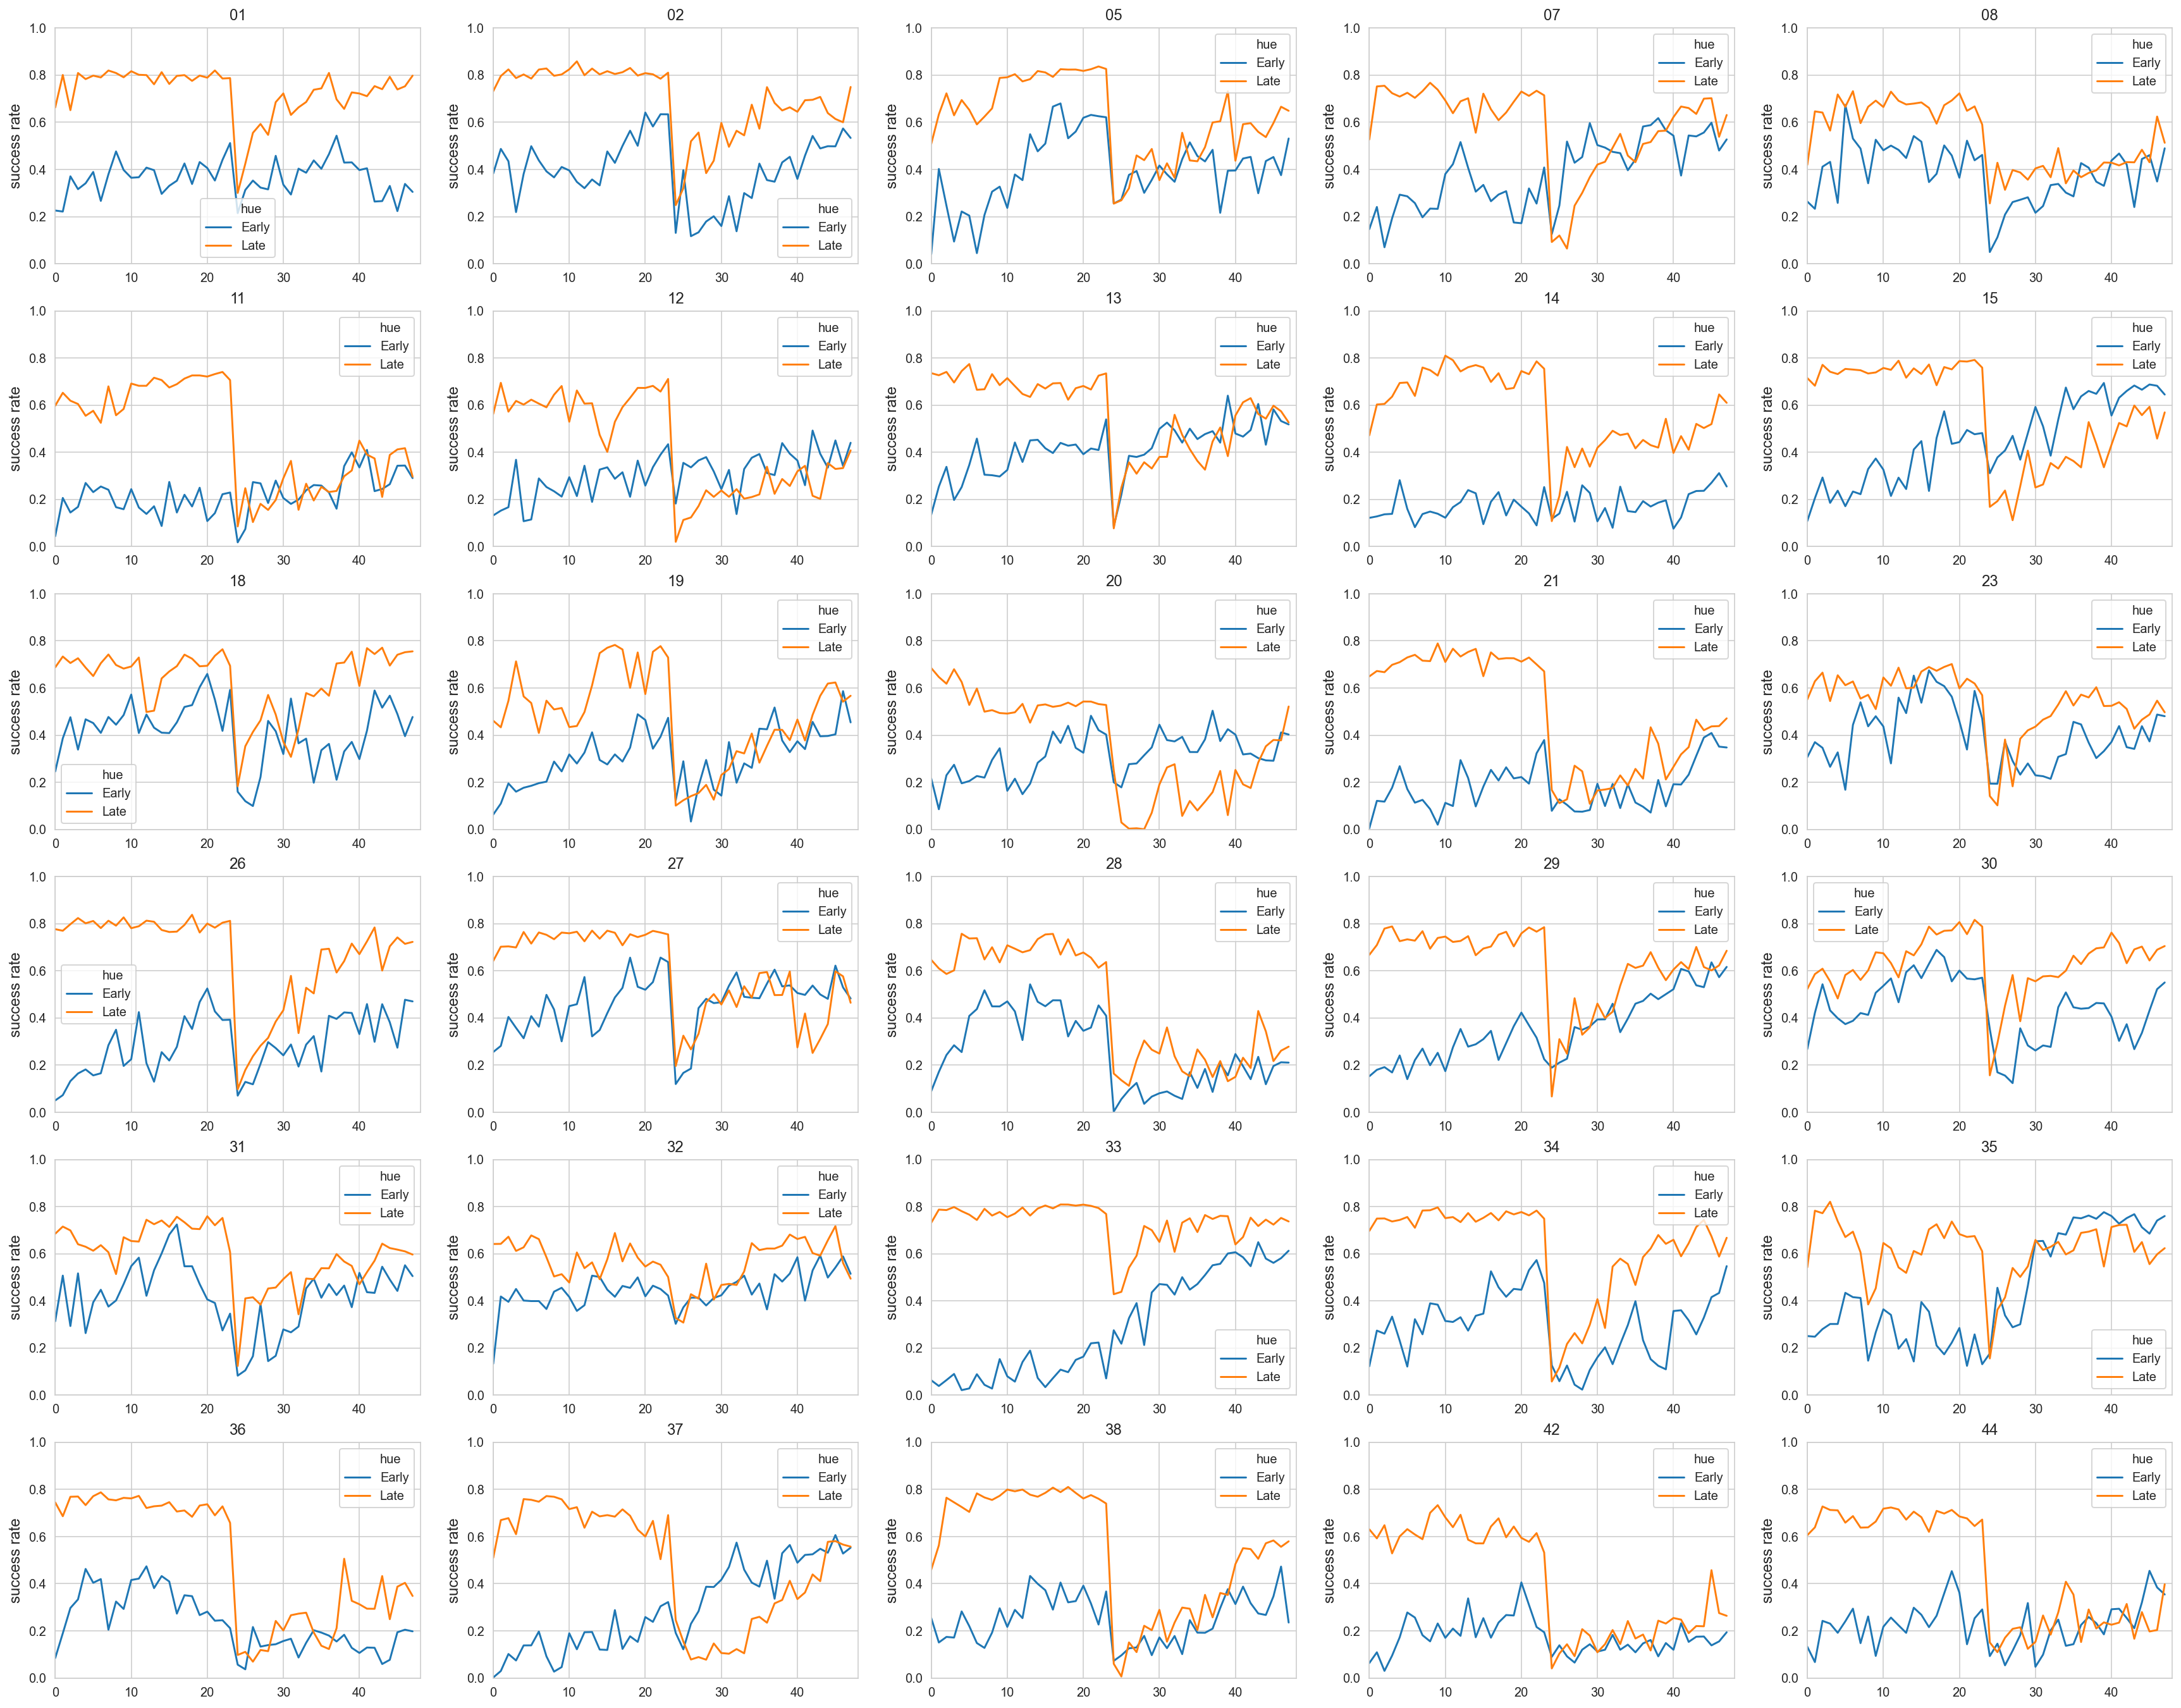

In [95]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 24)
sns.set_style('whitegrid')
for i, nn in enumerate(nn_list):
    subj = nn
    plt.subplot(6, 5, i+1)
#     sns.barplot(x='block', y='SR', data=dk[(dk.subj=='GA'+nn)|(dk.subj=='GB'+nn)], hue='hue', dodge=False)
    sns.lineplot(x='block', y='SR', data=dk[(dk.subj=='GA'+nn)|(dk.subj=='GB'+nn)], hue='hue')
    plt.title(subj)
    plt.ylim(0, 1)
    plt.xlim(0, ttt)
    plt.ylabel('success rate', size=12)
    plt.xlabel(None)
    plt.legend()

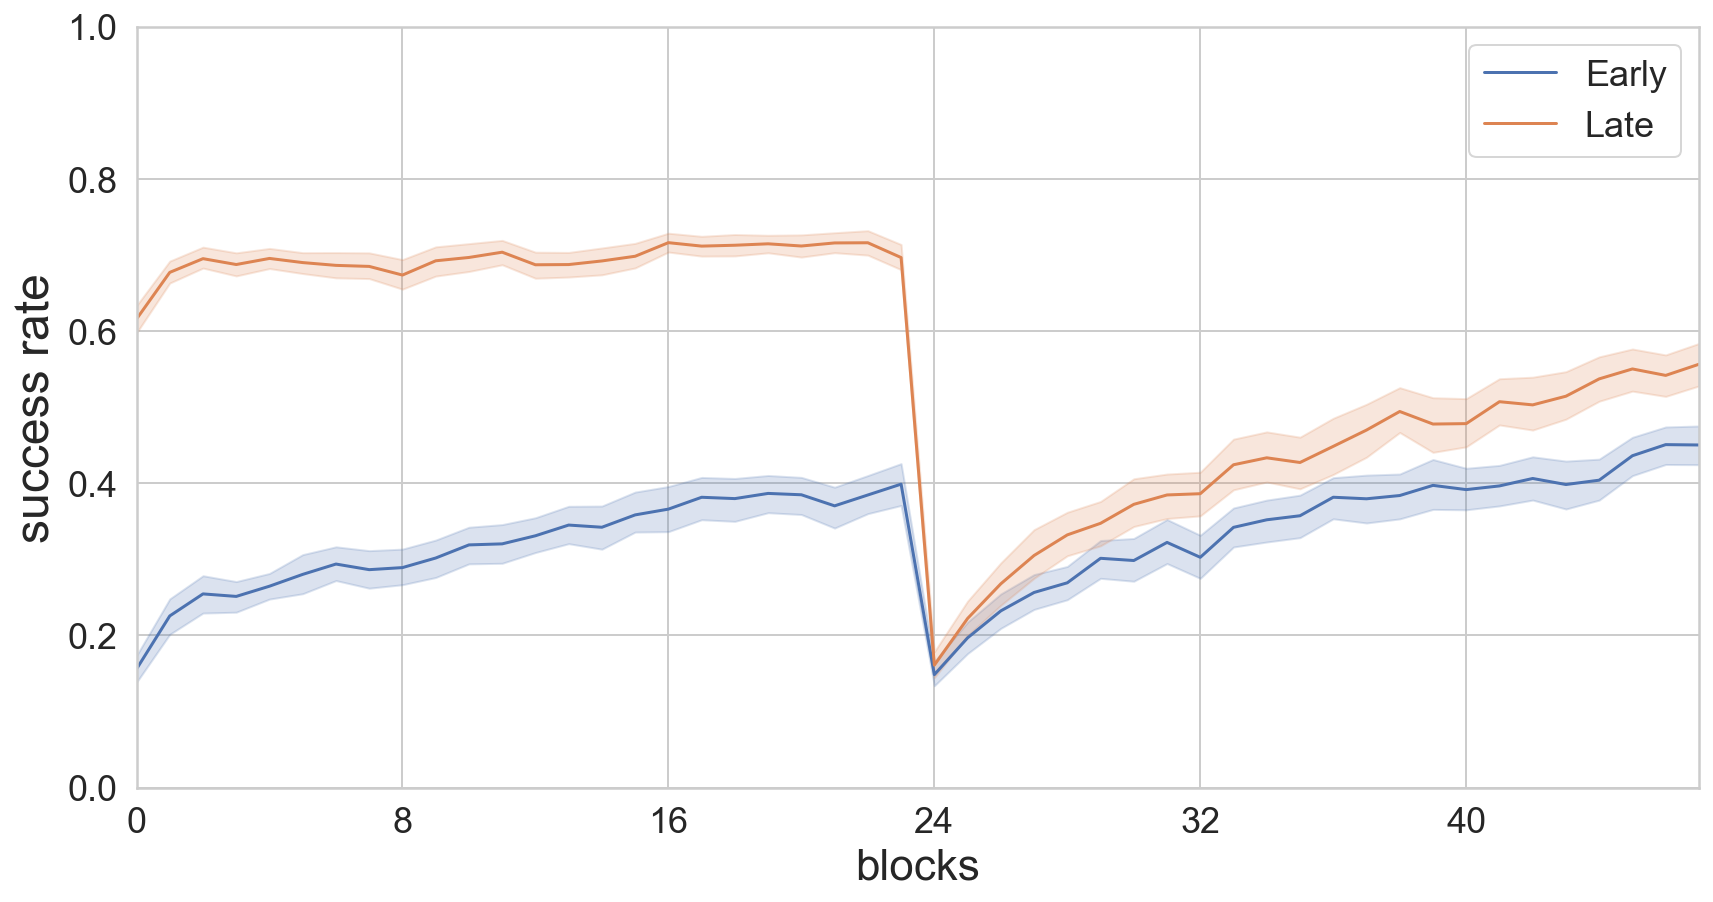

In [134]:
sns.set(style="whitegrid")

ax = plt.figure(figsize=(14, 7))
# sns.barplot(x='block', y='SR', data=dk, hue='hue', ci=100*sigma_1, capsize=.2, dodge=False)
sns.lineplot(x='block', y='SR', data=dk, hue='hue', ci=100*sigma_1)
plt.xlabel('blocks', size=22)
plt.ylabel('success rate', size=24)
plt.xticks(range(0,48,8),fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,47)
plt.ylim(0.,1.)
plt.legend(['Early','Late'], title=None, loc='best', fontsize=18)

# ax.savefig(join(output_dir,today+'.behav.group.png'), dpi=300)

## plot 2

In [47]:
temp = dk[dk['block']<24].groupby(['subj']).mean()
temp['hue'] = ['Early' if subj[1]=='A' else 'Late' for subj in temp.index]
temp

,SR,hue
subj,,
GA01,0.366991,Early
GA02,0.446898,Early
GA05,0.397407,Early
GA07,0.279699,Early
GA08,0.442072,Early
GA11,0.185579,Early
GA12,0.263993,Early
GA13,0.366285,Early
GA14,0.163391,Early


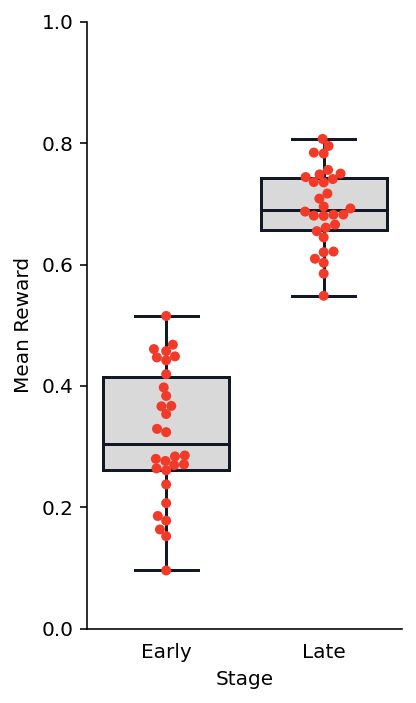

In [65]:
fig, ax = plt.subplots(figsize=(3, 5))

sns.boxplot(x='hue', y='SR', data=temp, palette=["#D9D9D9"])
sns.swarmplot(x='hue', y='SR', data=temp, size=5, color="#F23A29", linewidth=0)

plt.ylim(0., 1.)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.xlabel('Stage')
plt.ylabel('Mean Reward')

for i, artist in enumerate(ax.artists):
    artist.set_edgecolor("#131826")
    
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color("#131826")
        line.set_mfc("#131826")
        line.set_mec("#131826")
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
)

plt.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    right=False,       # ticks along the top edge are off
)

plt.tight_layout()

fig.set_facecolor('white')

# fig.savefig(fname=today+'_behav2.png', dpi=300)

## plot 3